In [113]:
# importing necessary libraries 

import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
# stops python from showing scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Import Data and drop unnecessary columns

In [114]:
data = pd.read_csv('/Users/stephen/Flatiron/Phase3/project_3/Data/training_set_features.csv', index_col='respondent_id')
target = pd.read_csv('/Users/stephen/Flatiron/Phase3/project_3/Data/training_set_labels.csv', index_col='respondent_id')
holdout_set = pd.read_csv('/Users/stephen/Flatiron/Phase3/project_3/Data/test_set_features.csv', index_col='respondent_id')

In [115]:
# We only need the 'h1n1_vaccine' column as our target variable so we'll turn it into a panda series with just that column. 
target = pd.Series(target['h1n1_vaccine'])


In [116]:
# inspect the values 
target.value_counts(normalize=True)


0   0.79
1   0.21
Name: h1n1_vaccine, dtype: float64

In [117]:

# drop unnecessary columns in features
drop_feats = ['opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','hhs_geo_region',
            'employment_industry','employment_occupation','census_msa']

features = data.drop(columns=drop_feats)

In [118]:

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

# Convert Ordinal categories 

In [119]:
num_cols = features.select_dtypes('number').columns
ord_cols = ['age_group', 'education',  'income_poverty', 'employment_status']
cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own']

In [120]:
features['age_group'].value_counts(dropna=False)

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [121]:
# Give categories values 

age_group_dict = {
np.NAN: -1, 
'18 - 34 Years': 1, 
'35 - 44 Years': 2, 
'45 - 54 Years': 3, 
'55 - 64 Years': 4, 
'65+ Years': 5, 
}

features['age_group_ordinal'] = features.age_group.map(age_group_dict).astype("category")
features['age_group_ordinal'].value_counts()

5    6843
4    5563
3    5238
1    5215
2    3848
Name: age_group_ordinal, dtype: int64

In [122]:
features['education'].value_counts(dropna=False)


College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
NaN                  1407
Name: education, dtype: int64

In [123]:
education_dict = {
    np.NAN: -1,
    '< 12 Years': 1, 
    '12 Years': 2, 
    'Some College': 3, 
    'College Graduate': 4
}

features['education_ordinal'] = features.education.map(education_dict).astype("category")
features['education_ordinal'].value_counts(ascending=True)

-1     1407
1      2363
2      5797
3      7043
4     10097
Name: education_ordinal, dtype: int64

In [124]:
features['income_poverty'].value_counts()


<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [125]:
features['employment_status'].value_counts()


Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [126]:
employment_dict = { 
    np.NAN: -1,
    'Unemployed': 1, 
    'Not in Labor Force': 2, 
    'Employed': 3
}

features['employment_status_ordinal'] = features.employment_status.map(employment_dict).astype("category")
features['employment_status_ordinal'].value_counts()

3     13560
2     10231
-1     1463
1      1453
Name: employment_status_ordinal, dtype: int64

In [127]:
features.shape

(26707, 31)

In [128]:
features.drop(columns=ord_cols, inplace=True)

# build Pipeline


In [129]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])


# create the preprocessor stage of final pipeline


preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', numeric_preprocessing_steps, num_cols), 
        ('category', cat_transformer, cat_cols)],
    remainder = "passthrough")

estimators = KNeighborsClassifier(weights='uniform', n_neighbors=2)


full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimators", estimators),])

In [130]:
# split data into a test set and a train set 

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.25, stratify=target)

In [131]:
# look at pipeline
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavi...
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')),
                                                 ('category',
              

In [132]:
# fit the training set 
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavi...
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')),
                                                 ('category',
              

In [133]:
full_pipeline.score(X_test, y_test)

0.7988617642653887

In [138]:
y_test.value_counts()

0    5258
1    1419
Name: h1n1_vaccine, dtype: int64

In [134]:
y_pred = full_pipeline.predict(X_test)

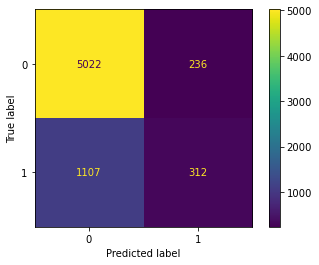

In [137]:
plot_confusion_matrix(full_pipeline, X_test, y_test)